In [1]:
from utils import resize
from shoeplotlib import plot_RBG_dist, average_shoe
from PIL import Image, ImageOps
import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
import seaborn as sns
from skimage.util import montage
from sklearn import decomposition
import re

import os
import shutil
import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
# directories
curr_path = os.getcwd()
project_path = os.path.join(curr_path, '..')
non_hype_path = os.path.join(project_path, 'data', 'non-hype')
data_path = os.path.join(project_path, 'data')
img_folders = ['stockx', 'goat', 'flight_club', 'non-hype']

In [3]:
hyped_info_df = pd.read_csv('hyped_info_df.csv')
non_hyped_info_df = pd.read_csv('non_hyped_info_df.csv')

In [4]:
# accents were causing trouble
change = [r'ç',r'é',r'ü']
change_to = ['c','e','u']
for i in range(len(change)):
    hyped_info_df.name = hyped_info_df.name.apply(lambda x: re.sub(change[i],change_to[i],x))
    hyped_info_df.path = hyped_info_df.path.apply(lambda x: re.sub(change[i],change_to[i],x))

# Exploratory Data Analysis

### Basic EDA

In [5]:
print(f'Total {hyped_info_df.shape[0]} images of  hyped shoe images')
print(f'Total {non_hyped_info_df.shape[0]} images of  non-hyped shoe images')

Total 2913 images of  hyped shoe images
Total 3845 images of  non-hyped shoe images


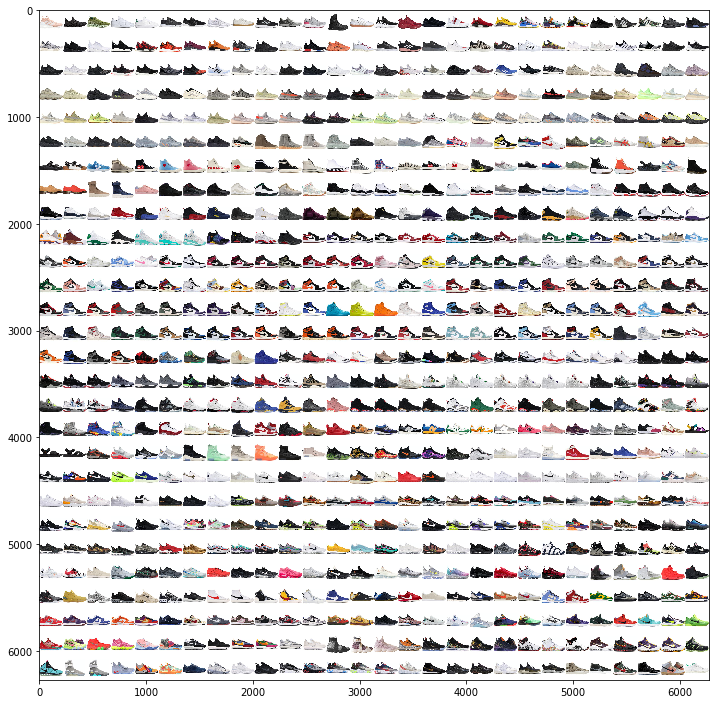

In [6]:
hyped_imgs = [cv2.imread(img)[:,:,::-1] for img in glob.glob(os.path.join(project_path, 'data', 'stockx_resized','**'))][:784]
hyped_imgs = np.stack(hyped_imgs)
plt.figure(figsize=(12,15))
plt.imshow(montage(hyped_imgs, multichannel=True))

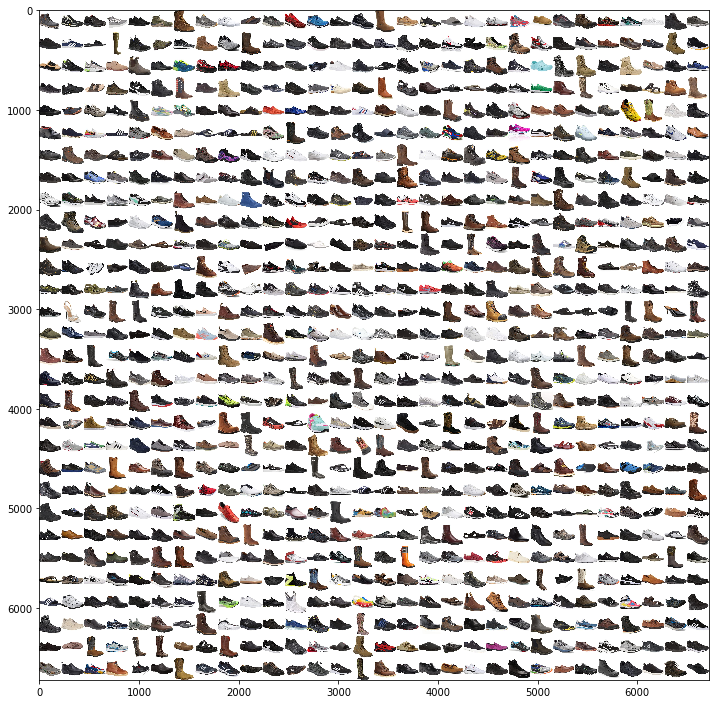

In [7]:
non_hyped_imgs = np.array([cv2.imread(img)[:,:,::-1] for img in glob.glob(os.path.join(project_path, 'data', 'non-hype_resized','**'))])[:900]
non_hyped_imgs = np.atleast_3d(non_hyped_imgs)
plt.figure(figsize=(12,15))
plt.imshow(montage(non_hyped_imgs, multichannel=True))

### Raw image dimensions

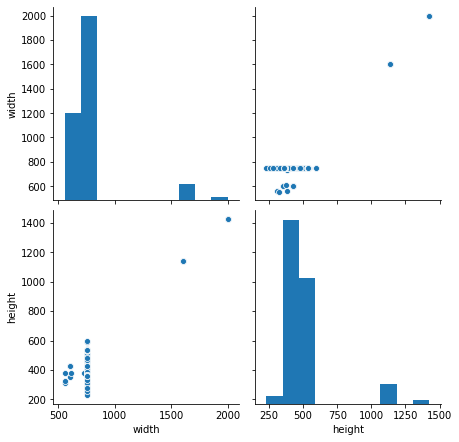

In [8]:
sns.pairplot(hyped_info_df[['width','height']],height=3)

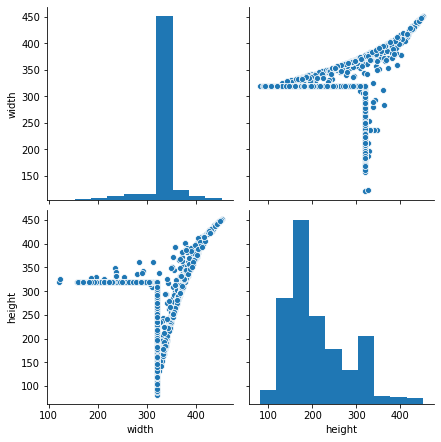

In [9]:
sns.pairplot(non_hyped_info_df[['width','height']],height=3)

### Brand distribution for hyped shoes

In [10]:
hyped_info_df.brand.value_counts()

jordan               1322
nike                  903
adidas                470
converse               58
vans                   32
new_balance            26
revenge_x_storm        25
reebok                 13
gucci                   9
alexander_mcqueen       9
balenciaga              9
asics                   6
offwhite                5
dior                    5
puma                    5
dr_martens              3
crocs                   3
birkenstock             2
fear_fo_god             2
a_bathing_ape           2
dolce_gabbana           1
louis_vuitton           1
saucony                 1
diadora                 1
Name: brand, dtype: int64

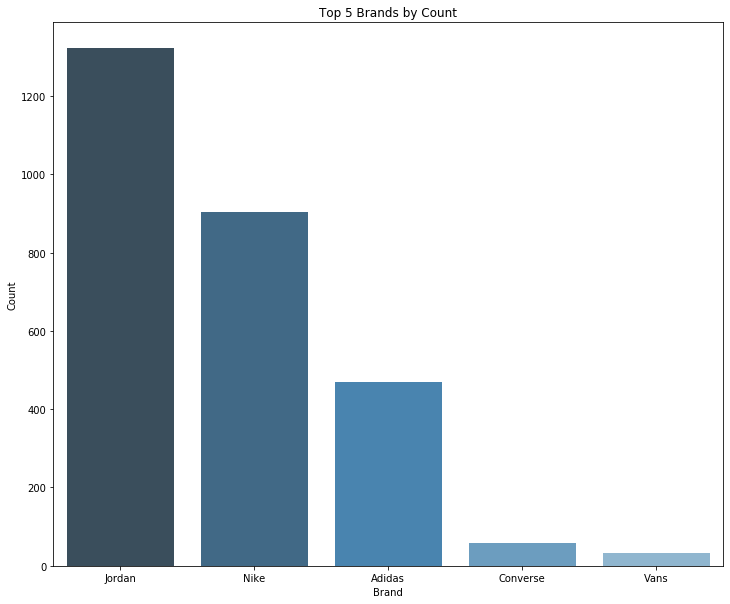

In [11]:
# graph the top 5 hyped brands
plt.figure(figsize=(12,10))
top_brands = [brand.title() for brand in hyped_info_df.brand.value_counts().index[:5]]
top_counts = hyped_info_df.brand.value_counts().iloc[:5]
ax = sns.barplot(x='Brand',y='Count',
                 data=pd.DataFrame(zip(top_counts, top_brands), columns=['Count','Brand']),
                 palette=("Blues_d"))
plt.title('Top 5 Brands by Count')
sns.set_context("paper")

### Plotting the RGB Color distributions for hyped and non-hyped shoes

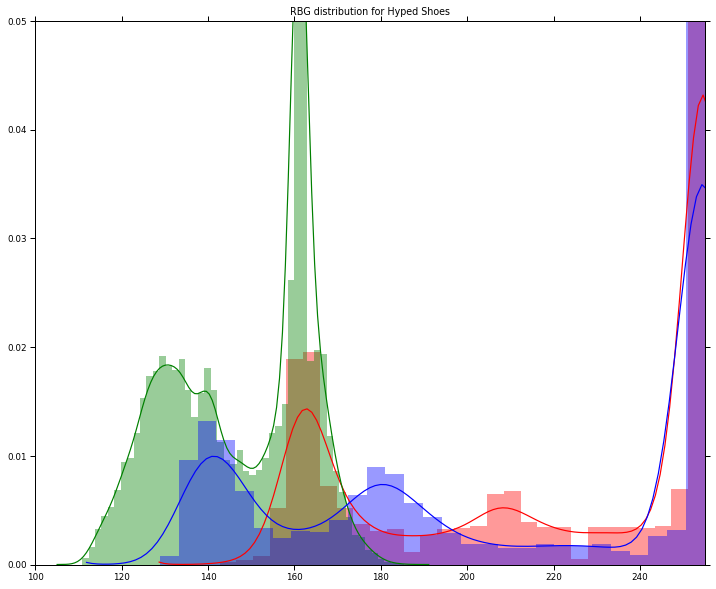

In [12]:
# graphing hyped shoes mean rgb distribution
hype_rgb = np.zeros((224, 224, 3))
num_images = 0
skips = []

for folder in img_folders:
    if folder == 'non-hype':
        continue
    files = glob.glob(os.path.join(data_path,f'{folder}_resized','**'))
    for file in files:
        # some files are not being read properly
        hype_rgb += (cv2.imread(file)[:,:,::-1] if cv2.imread(file) is not None else 0)
        if cv2.imread(file)[:,:,::-1] is None:
            num_images -= 1
            skips.append(file)
    num_images += len(files)
hype_rgb /= num_images
hype_rgb = hype_rgb.reshape(3,224,224)

plot_RBG_dist(hype_rgb,'Hyped',(100,255))

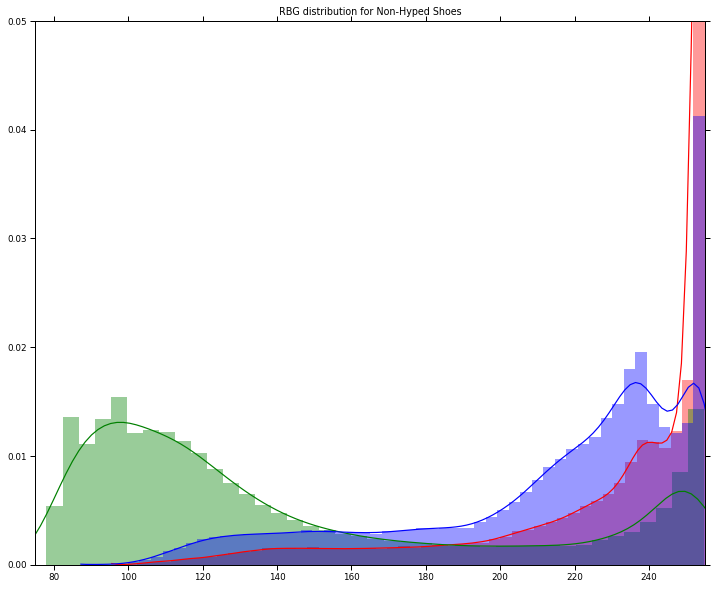

In [13]:
# graphing non-hyped shoes mean rgb distribution
files = glob.glob(os.path.join(data_path,'non-hype_resized','**'))
non_hype_rgb = np.zeros((224, 224, 3))
for file in files:
    non_hype_rgb += cv2.imread(file)[:,:,::-1]
non_hype_rgb = non_hype_rgb / len(files)
non_hype_rgb = non_hype_rgb.reshape(3,224,224)

plot_RBG_dist(non_hype_rgb,'Non-Hyped',(75,255))

### Mutual information between hyped/non-hyped shoe and a recently released highly coveted sneaker

In [14]:
ben_jerry_dunks = Image.open(os.path.join(os.getcwd(),'ben_jerry_dunks.jpg'))
target_size = (224,224)
resized_dunks_img = resize(ben_jerry_dunks.copy(), target_size)
resized_dunks_np = np.array(resized_dunks_img).reshape(3,224,224)

In [15]:
colors = ['blue','green','red']
MI_non_hype, MI_hype, hype_non_hype = [], [], []
for i,color in enumerate(colors):
    MI_non_hype.append(mutual_info_score(resized_dunks_np[i].reshape(-1), non_hype_rgb[i].reshape(-1)))
    MI_hype.append(mutual_info_score(resized_dunks_np[i].reshape(-1), hype_rgb[i].reshape(-1)))
    hype_non_hype.append(mutual_info_score(non_hype_rgb[i].reshape(-1), hype_rgb[i].reshape(-1)))
print(f'The mean RGB Mutual Information Score between Ben&Jerry Dunks and Hyped Shoes is {sum(MI_hype)/3}')
print(f'The mean RGB Mutual Information Score between Ben&Jerry Dunks and Non-Hyped Shoes is {sum(MI_non_hype)/3}')
print(f'The mean RGB Mutual Information Score between Hyped and Non-Hyped Shoes is {sum(hype_non_hype)/3}')

The mean RGB Mutual Information Score between Ben&Jerry Dunks and Hyped Shoes is 1.7543168670080345
The mean RGB Mutual Information Score between Ben&Jerry Dunks and Non-Hyped Shoes is 1.8032898007012639
The mean RGB Mutual Information Score between Hyped and Non-Hyped Shoes is 8.086841391765558


### Average Hyped Shoe using PCA

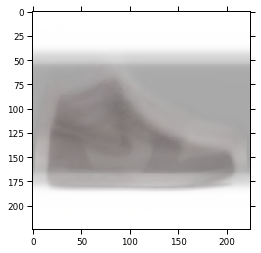

In [16]:
hyped_np = np.array([cv2.imread(img)[:,:,::-1].flatten() for img in hyped_info_df.path])
hyped_np = np.stack(hyped_np)
average_shoe(hyped_np)

In [17]:
mean, eigenVectors = cv2.PCACompute(hyped_np, mean=None, maxComponents=100)

In [24]:
sz = (224,224,3)
averageShoe = mean.reshape(sz)

eigenShoes = []
for eigenVector in eigenVectors:
    eigenShoe = eigenVector.reshape(sz)
    eigenShoes.append(eigenShoe)

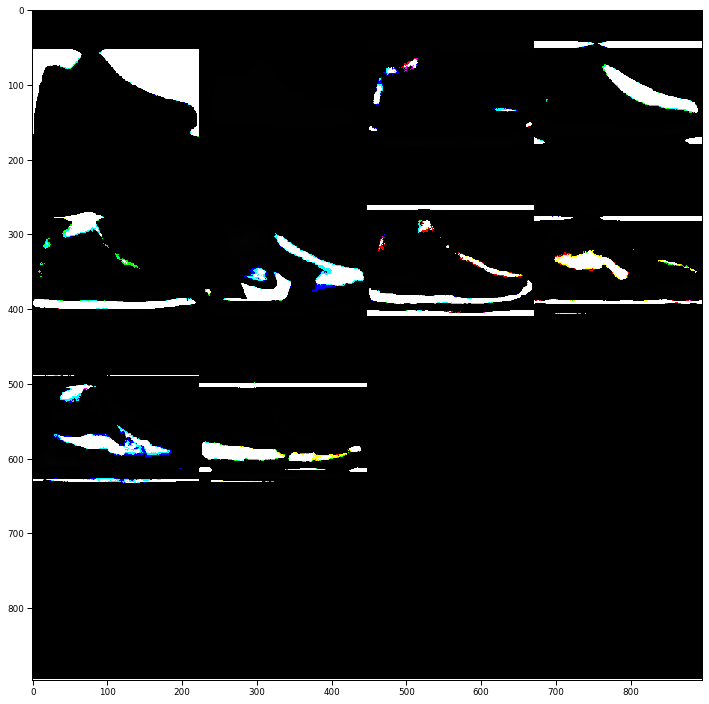

In [50]:
plt.figure(figsize=(12,15))
plt.imshow(montage(np.stack(eigenShoes)*255, multichannel=True).astype(np.uint8))

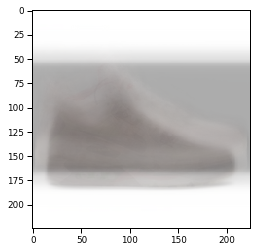

In [38]:
no_aj1_df = hyped_info_df[~((hyped_info_df.name.str.contains('jordan'))&(hyped_info_df.name.str.contains('1')))]
hyped_np_no_aj1 = np.array([cv2.imread(img)[:,:,::-1].flatten() for img in no_aj1_df.path])
hyped_np_no_aj1 = np.stack(hyped_np_no_aj1)
average_shoe(hyped_np_no_aj1)

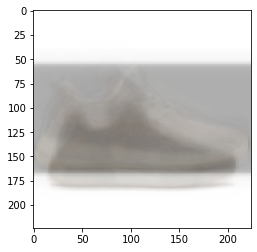

In [7]:
adidas_df = hyped_info_df[hyped_info_df.brand=='adidas']
adidas_np = np.array([cv2.imread(img)[:,:,::-1].flatten() for img in adidas_df.path])
adidas_np = np.stack(adidas_np)
average_shoe(adidas_np,n_components=350)

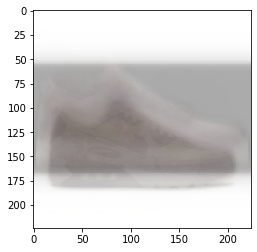

In [8]:
nike_df = hyped_info_df[hyped_info_df.brand=='nike']
nike_np = np.array([cv2.imread(img)[:,:,::-1].flatten() for img in nike_df.path])
nike_np = np.stack(nike_np)
average_shoe(nike_np,n_components=100)

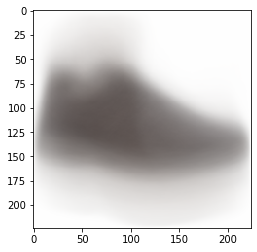

In [9]:
non_hype_np = np.array([cv2.imread(img)[:,:,::-1].flatten() for img in non_hyped_info_df.path])
non_hype_np = np.stack(non_hype_np)
average_shoe(non_hype_np, n_components=100)